# Pandora metrics

## Purpose of this notebook

Purpose of this notebook is to introduce the definition of some important metrics, and produce the corresponding reference peformance results achieved by Pandora [Eur. Phys. J. C 78, 82 (2018), https://arxiv.org/abs/1708.03135], the reconstruction toolkit used in many MicroBooNE publications.

## Load useful libraries, utilities, and data

Get libraries, utils, and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from microboone_utils import *
from plot_utils import Eff

In [3]:
from pynuml.io import File

In [4]:
f = File("NeutrinoML_Open_NoWire_750evts.h5")

startevt = 0
nevts = 2000 #anything from 0 to len(f)

tables = ['event_table','hit_table','edep_table','pandoraHit_table','pandoraPrimary_table','particle_table','pandoraPfp_table']
for t in tables: f.add_group(t)
f.read_data(startevt, nevts)

## Neutrino Purity for Pandora Slices

Convert hit, pandoraHit, and edep tables into data frames. The pandoraHit table contains information about how pandora clustered those hits. The edep table contains the truth information about the hits. Merge the data frames based on the hit_id and the edep with largest contribution to the hit in terms for energy fraction.

In [5]:
hits = f.get_dataframe_evt("hit_table")

pandhits = f.get_dataframe_evt("pandoraHit_table")
hits = hits.merge(pandhits, on=["evt_idx","hit_id"])

edeps = f.get_dataframe_evt("edep_table")
edeps = edeps.sort_values(by=['energy_fraction'], ascending=False, kind='mergesort').drop_duplicates(["evt_idx","hit_id"])

hits = hits.merge(edeps, on=["evt_idx","hit_id"], how="left")
hits['g4_id'] = hits['g4_id'].fillna(-1)
hits = hits.fillna(0)


Pandora separates hits into "slices", where each slice is meant to collect hits from a different interaction (whether from the neutrino or from different cosmic rays). Identifying the neutrino interaction slice is a fundamental step for the reconstruction of the neutrino interaction.

We first extract the hit information counting the hits in each slice for each event.

In [6]:
slicehits = hits.groupby(["evt_idx","slice_id"]).size().reset_index().rename(columns={0:'slhits'})
slnuhits = hits[hits['g4_id']>=0].groupby(["evt_idx","slice_id"]).size().reset_index().rename(columns={0:'nuslhits'})
allnuhits = hits[hits['g4_id']>=0].groupby(["evt_idx"]).size().reset_index().rename(columns={0:'nuhitstot'})

slicehits = slicehits.merge(slnuhits, on=["evt_idx","slice_id"], how='left')
slicehits = slicehits.merge(allnuhits, on=["evt_idx"], how='left')
slicehits['nuslhits'] = slicehits['nuslhits'].fillna(0)
slicehits['nuhitstot'] = slicehits['nuhitstot'].fillna(0)

We can print the information about the slice with most hits from the neutrino interaction in each event:

In [7]:
slicehits.sort_values(by=['nuslhits'], ascending=False).drop_duplicates(['evt_idx']).sort_values(by=['evt_idx'])

,evt_idx,slice_id,slhits,nuslhits,nuhitstot
6,0,5,4429,92.0,111.0
19,1,0,2454,2260.0,2332.0
53,2,15,273,0.0,0.0
65,3,5,2076,52.0,64.0
81,4,6,1209,33.0,37.0
...,...,...,...,...,...
16343,745,8,1270,1079.0,1114.0
16358,746,3,1733,1263.0,1299.0
16392,747,12,1061,726.0,749.0
16410,748,0,2053,32.0,63.0


We can now plot the fraction of neutrino hits (purity) in each pandora slice, including both those identified as neutrino and those identified as cosmics. Ideally we would like to have two populations, one peaking at zero (for cosmic slices) and one peaking at one (for neutrino slices).

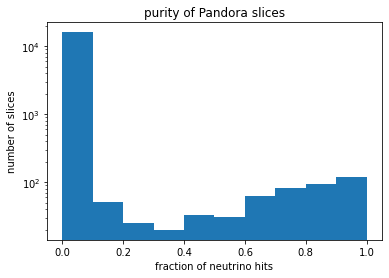

In [8]:
plt.hist(slicehits['nuslhits']/slicehits['slhits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora slices')
plt.show()

Now, in order to make a more detailed analysis of the slice properties, we need to use the "pandoraPrimary" table, which gathers information from the slice identification and high-level neutrino reconstruction. Primary here refers to the particle entering the detector and interacting with the argon. Products of this interaction would be considered "secondaries" and their info is in the "pandoraPfp_table".

In [9]:
primary = f.get_dataframe_evt("pandoraPrimary_table")
primary.columns

Index(['flashmatch_score', 'nu_score', 'slice_id', 'slice_pdg', 'vtx_x',
       'vtx_y', 'vtx_z', 'vtx_wire_pos_0', 'vtx_wire_pos_1', 'vtx_wire_pos_2',
       'vtx_wire_time', 'evt_idx'],
      dtype='object')

Since slices identified as cosmics may contain more than one identified cosmic interaction, if we want to study slice properties we need to identify these cases and drop the corresponding duplicate entries. By merging with the slicehits dataframe we now have access to both the slice hits and slice indentification infomation.

In [10]:
slices = primary.drop_duplicates(["evt_idx","slice_id"])
slices = slices.merge(slicehits, on=["evt_idx","slice_id"], how='left')

In [11]:
slices

,flashmatch_score,nu_score,slice_id,slice_pdg,vtx_x,vtx_y,vtx_z,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,vtx_wire_time,evt_idx,slhits,nuslhits,nuhitstot
0,36.223362,-999.0,0,13,148.910645,112.791679,596.446350,1007,1652,1987,3512.572021,0,1495,8.0,111.0
1,126.976807,-999.0,1,13,15.657176,114.753769,359.529266,606,1263,1198,1085.212769,0,1499,3.0,111.0
2,49.429428,-999.0,2,13,248.027817,111.200584,142.987137,255,892,476,5318.101074,0,1221,0.0,111.0
3,29.871815,-999.0,3,13,251.751404,116.713654,10.067689,18,686,33,5385.930176,0,1198,0.0,111.0
4,13.516474,-999.0,4,13,130.091476,113.328796,438.976685,743,1391,1462,3169.760010,0,889,8.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16393,9999.000000,-999.0,11,13,-43.938816,-42.131100,993.757324,2116,1867,3312,-0.394125,749,371,0.0,8.0
16394,9999.000000,-999.0,12,13,307.433075,-33.533604,577.403320,1397,1198,1924,6400.233398,749,293,0.0,8.0
16395,8.828668,-999.0,13,13,159.785706,-72.033768,1002.200378,2216,1795,3340,3710.673340,749,236,0.0,8.0
16396,9999.000000,-999.0,14,13,-43.962833,-101.242180,128.592087,845,255,428,-0.831627,749,152,0.0,8.0


We can now separate the two populations mentioned above, by selecting the slices identified as neutrino (pdg code 12 or 14, for nue and numu) from those identified as cosmics.

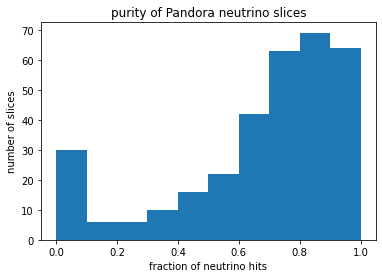

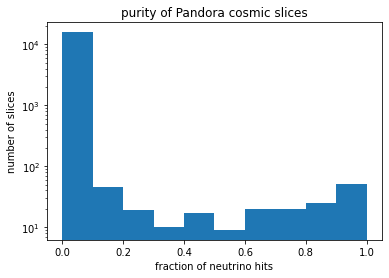

In [12]:
nuslices = slices.query('slice_pdg==12 or slice_pdg==14')
plt.hist(nuslices['nuslhits']/nuslices['slhits'],bins=10,range=(0,1))
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora neutrino slices')
plt.show()

cosmslices = slices.query('slice_pdg!=12 and slice_pdg!=14')
plt.hist(cosmslices['nuslhits']/cosmslices['slhits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora cosmic slices')
plt.show()

We can also look at another metric: completeness, which is defined as the fraction of neutrino-induced hits in the event that are collected in the slice.

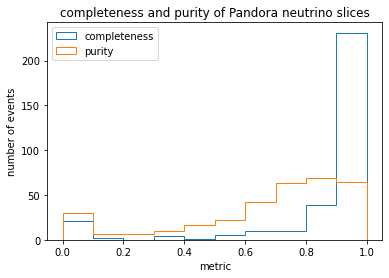

In [13]:
nuslices = slices.query('slice_pdg==12 or slice_pdg==14')
plt.hist(nuslices.eval('nuslhits/nuhitstot'),bins=10,range=(0,1),label='completeness',histtype='step')
plt.hist(nuslices.eval('nuslhits/slhits'),bins=10,range=(0,1),label='purity',histtype='step')
plt.xlabel('metric')
plt.ylabel('number of events')
plt.title('completeness and purity of Pandora neutrino slices')
plt.legend(loc=2)
plt.show()

## Neutrino Slice ID Efficiency and Vertex Resolution

Get the event table, where the true neutrino interaction vertex position is stored. This will compared to the quantity reconstructed by Pandora, i.e. the vertex position of the slices identified as neutrino interactions.

In [14]:
event = f.get_dataframe_evt("event_table")

From the slice data frame, pick the slice with most neutrino hits, and merge the result into the event data frame. Also, add a column based on the'isPosInActiveVolume' function from microboone_utils.py, which checks if the simulated neutrino interaction takes place in the detector active volume or not.

In [15]:
mostnuslice = slices.sort_values(by=['nuslhits'], ascending=False).drop_duplicates(["evt_idx"]).sort_values(by=['evt_idx'])

In [16]:
event = event.merge(mostnuslice, on=["evt_idx"], how='left')
event['slice_pdg'] = event['slice_pdg'].fillna(-1)
event['inActiveVol'] = event.apply(lambda x: isPosInActiveVolume(x.nu_vtx_x, x.nu_vtx_y, x.nu_vtx_z), axis=1)

In [17]:
event

,run,subrun,event,is_cc,lep_energy,nu_dir_x,nu_dir_y,nu_dir_z,nu_energy,nu_pdg,...,vtx_y,vtx_z,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,vtx_wire_time,slhits,nuslhits,nuhitstot,inActiveVol
0,7419,0,1,1,1.037216,0.003574,-0.005167,0.999980,1.613928,14,...,116.920578,902.997314,1506,2175,3009,4437.240723,4429,92.0,111.0,False
1,7419,0,44,1,1.044675,0.004616,-0.001963,0.999987,1.362572,14,...,-36.111881,2.615223,447,233,8,3373.541016,2454,2260.0,2332.0,False
2,7419,1,58,0,0.580640,0.002706,-0.002020,0.999994,0.895199,14,...,-86.089211,294.522522,1078,575,981,6253.200195,273,0.0,0.0,False
3,7419,1,76,1,0.755117,0.000081,-0.003100,0.999995,0.846823,14,...,91.541428,768.175171,1354,1877,2560,3545.526611,2076,52.0,64.0,False
4,7419,1,91,1,0.190239,0.006076,0.000356,0.999981,0.343379,14,...,108.019768,427.965454,740,1358,1426,4218.995605,1209,33.0,37.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,7625,174,8746,1,0.577493,0.004926,-0.002316,0.999985,1.079156,14,...,-34.617970,728.691589,1653,1447,2428,4512.101074,1270,1079.0,1114.0,True
746,7625,175,8755,1,1.121700,0.002805,-0.000753,0.999996,1.894746,14,...,39.855598,480.488373,1024,1248,1601,2652.091309,1733,1263.0,1299.0,True
747,7625,175,8772,1,0.468061,0.003891,0.000966,0.999992,1.008284,14,...,108.505074,826.764709,1403,2024,2755,3143.082031,1061,726.0,749.0,True
748,7625,175,8776,1,0.358741,0.004111,-0.004689,0.999981,0.753859,14,...,84.099083,-8.684996,81,561,0,4422.285645,2053,32.0,63.0,False


We now use a simple efficiency function (defined in plot_utils.py) to plot the efficiency for tagging with label 12 or 14 the slice with most neutrino hits.

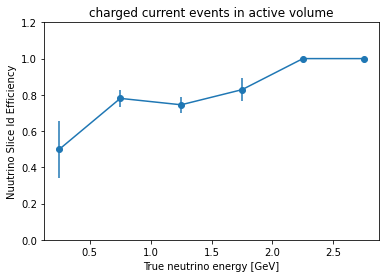

In [18]:
bin_edges = np.linspace(0,3,7)
centers,vals,errs = Eff(event,'nu_energy','slice_pdg==12 or slice_pdg==14','is_cc==1 and inActiveVol==True',bin_edges)
plt.errorbar(centers,vals,yerr=errs,fmt='o-')
plt.xlabel('True neutrino energy [GeV]')
plt.ylabel('Nuutrino Slice Id Efficiency')
plt.title('charged current events in active volume')
plt.ylim(0.,1.2)
plt.show()


For events where the slice is correctly found, we can now check the accuracy of the neutrino vertex position reconstruction, both in cartesian coordinates and in wire units.

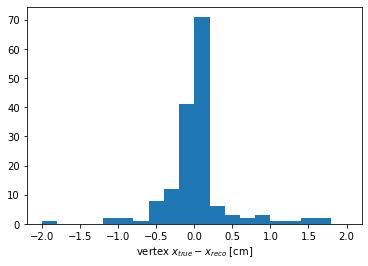

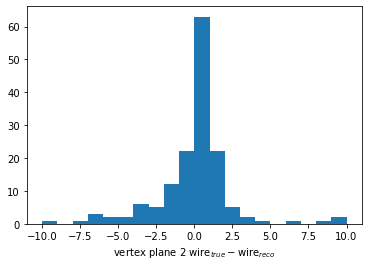

In [19]:
nuvtx = event.query('(slice_pdg==12 or slice_pdg==14) and slice_pdg>0 and is_cc==1 and inActiveVol==True')

plt.hist(nuvtx.eval('nu_vtx_corr_x-vtx_x'),bins=np.linspace(-2,2,21))
plt.xlabel(r'vertex $x_{true}-x_{reco}$ [cm]')
plt.show()

plt.hist(nuvtx.eval('nu_vtx_wire_pos_2-vtx_wire_pos_2'),bins=np.linspace(-10,10,21))
plt.xlabel(r'vertex plane 2 wire$_{true}-$wire$_{reco}$')
plt.show()

## Particle Completeness and Purity

We now want to study the performance at particle level. First we need to take the particle table (containing the true particle info, with category and instance labels). We then get the pandoraPfp table, which contains the pandora reconstructed particle information. We then merge these data frames, as well as the slice data frame used earlier, with the hit data frame.

In [20]:
particles = f.get_dataframe_evt("particle_table")
pfps = f.get_dataframe_evt("pandoraPfp_table")

In [21]:
hits = hits.merge(slices[["evt_idx","slice_id","slice_pdg"]], on=["evt_idx","slice_id"], how='left')
hits = hits.merge(particles, on=["evt_idx","g4_id"], how="left")
hits = hits.merge(pfps[["evt_idx","pfp_id","pfp_pdg","trkshr_score"]], on=["evt_idx","pfp_id"], how='left')

We now want to count the number of hits per true particle instance and per reconstructed particle (pfp).

In [22]:
pfphits = hits.groupby(["evt_idx","slice_pdg","slice_id","pfp_id","trkshr_score"]).size().reset_index().rename(columns={0:'pfphits'})
insthits = hits.groupby(["evt_idx","category","instance"]).size().reset_index().rename(columns={0:'insthits'})
pfpinsthits = hits.groupby(["evt_idx","slice_pdg","slice_id","pfp_id","category","instance"]).size().reset_index().rename(columns={0:'pfpinsthits'})

pfpinsthits = pfpinsthits.merge(pfphits, on=["evt_idx","slice_id","pfp_id","slice_pdg"], how='left')
pfpinsthits = pfpinsthits.merge(insthits, on=["evt_idx","category","instance"], how='left')
pfpinsthits.fillna(-1,inplace=True)

In [23]:
pfpinsthits

,evt_idx,slice_pdg,slice_id,pfp_id,category,instance,pfpinsthits,trkshr_score,pfphits,insthits
0,0,13.0,0,-1,7.0,-1.0,8,-1.0,-1.0,111
1,0,13.0,1,-1,7.0,-1.0,3,-1.0,-1.0,111
2,0,13.0,4,-1,7.0,-1.0,8,-1.0,-1.0,111
3,0,13.0,5,-1,7.0,-1.0,92,-1.0,-1.0,111
4,1,13.0,1,-1,7.0,-1.0,2,-1.0,-1.0,15
...,...,...,...,...,...,...,...,...,...,...
5455,748,13.0,1,-1,7.0,-1.0,8,-1.0,-1.0,63
5456,748,13.0,2,-1,7.0,-1.0,16,-1.0,-1.0,63
5457,748,13.0,9,-1,7.0,-1.0,5,-1.0,-1.0,63
5458,748,13.0,16,-1,7.0,-1.0,2,-1.0,-1.0,63


We can select which category of particles we want to study, based on the label enum in microboone_utils.py. Then we select entries in the data frame for instances of this category and pfps in the neutrino slice.

In [24]:
selcategory = category.photon #1:muon, 3:proton, 4:electron, 8:photon, see label microboone_utils.py
print('notebook will produce performance for instances of label:',category(selcategory).name)

notebook will produce performance for instances of label: photon


In [25]:
selhits = pfpinsthits.query('(slice_pdg==12 or slice_pdg==14) and category==%i'%selcategory.value)
selhits = selhits.sort_values(by=['pfpinsthits'], ascending=False)
selhits.drop_duplicates(["evt_idx","instance"], inplace=True)

In [26]:
selhits

,evt_idx,slice_pdg,slice_id,pfp_id,category,instance,pfpinsthits,trkshr_score,pfphits,insthits
3631,511,14.0,1,1,8.0,1.0,1132,0.797978,1848.0,1354
4156,580,12.0,3,3,8.0,1.0,884,0.035438,1108.0,926
338,51,12.0,9,9,8.0,1.0,547,0.004916,550.0,642
1322,190,14.0,3,5,8.0,1.0,503,0.939164,1085.0,715
1184,172,12.0,8,10,8.0,0.0,475,0.013698,510.0,642
...,...,...,...,...,...,...,...,...,...,...
453,70,14.0,12,-1,8.0,1.0,30,-1.000000,-1.0,30
1780,259,14.0,6,-1,8.0,2.0,11,-1.000000,-1.0,92
341,51,12.0,9,12,8.0,0.0,8,0.988008,357.0,13
3826,540,14.0,15,16,8.0,0.0,6,0.570010,174.0,6


At this point we can plot the purity and completeness for identifying instances of this category.

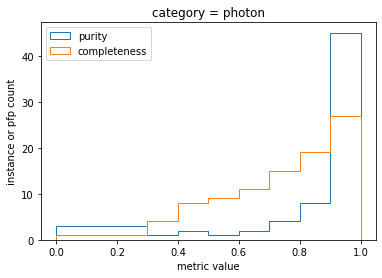

In [27]:
purity = selhits['pfpinsthits']/selhits['pfphits']
completeness = selhits['pfpinsthits']/selhits['insthits']
plt.hist(purity,histtype='step',label='purity',bins=np.linspace(0,1,11))
plt.hist(completeness,histtype='step',label='completeness',bins=np.linspace(0,1,11))
plt.legend(loc=2)
plt.xlabel('metric value')
plt.ylabel('instance or pfp count')
plt.title('category = %s'%category(selcategory).name)
plt.show()

We can also check the value of the track-shower discriminator from Pandora for particles of this category. Values close to -1 are more shower-like, while those close to 1 are more track-like. We expect photons and electrons to be shower-like, while muons, protons, and charged pions to be track-like.

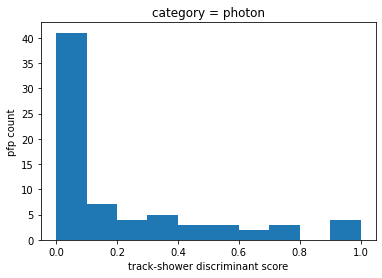

In [28]:
plt.hist(selhits['trkshr_score'],bins=np.linspace(0,1,11))
plt.xlabel('track-shower discriminant score')
plt.ylabel('pfp count')
plt.title('category = %s'%category(selcategory).name)
plt.show()